In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [3]:
from sklearn. ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Wczytanie danych

Wczytanie df z pliku uzupełnionego o współrzędne z wybranymi kolumnami. Uwzlędniamy tylko kolumny z danymi, które są znane przed odlotem.
Odrzucone zostają wszystkie dane związane z czasem i powodem opóźnienia.
Targetem jest opóźnienie przylotu 'ARRIVAL_DELAY'.

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df_flights = pd.read_csv('/content/drive/MyDrive/df_flights_sel.csv')

In [7]:
df_flights.sample(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,O_LATITUDE,O_LONGITUDE,D_LATITUDE,D_LONGITUDE
5229491,11,23,1,MQ,ORD,GRB,1655,173,1.0,0,0,41.97960,-87.90446,44.48507,-88.12959
5081706,11,14,6,OO,LAX,SBP,710,156,-13.0,0,0,33.94254,-118.40807,35.23706,-120.64239
3950787,9,2,3,OO,BUR,SFO,1857,326,70.0,0,0,34.20062,-118.35850,37.61900,-122.37484
2213502,5,21,4,AA,JFK,DFW,650,1391,7.0,0,0,40.63975,-73.77893,32.89595,-97.03720
2395456,6,1,1,NK,FLL,ACY,1445,977,34.0,0,0,26.07258,-80.15275,39.45758,-74.57717
4966559,11,6,5,DL,LGA,FLL,1840,1076,-37.0,0,0,40.77724,-73.87261,26.07258,-80.15275
2381567,5,31,7,US,CLT,BWI,1750,361,-7.0,0,0,35.21401,-80.94313,39.17540,-76.66820
5366088,12,2,3,WN,DCA,MCO,1600,759,12.0,0,0,38.85208,-77.03772,28.42889,-81.31603
451033,1,30,5,OO,IAH,DFW,1430,224,-8.0,0,0,29.98047,-95.33972,32.89595,-97.03720
4279450,9,24,4,UA,SAN,IAH,909,1303,-21.0,0,0,32.73356,-117.18966,29.98047,-95.33972


# Wstępna analiza - wykresy

W tabeli mamy ujednolicone już kody lotnisk i ich współrzędne.
Wybrane cechy są jednak słabo skorelowane.

In [ ]:
corr = df_flights.corr()

<ipython-input-7-5b61b826342f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_flights.corr()


<Axes: >

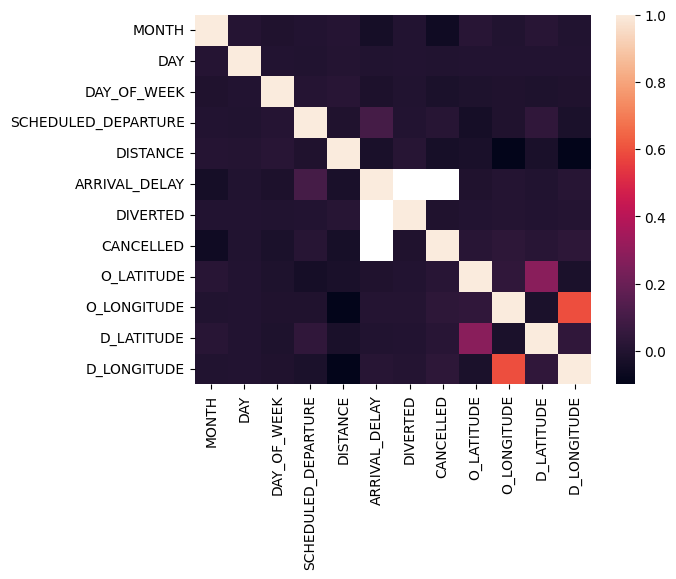

In [ ]:
sns.heatmap(corr)

Średnie opóźnienie przylotów w zależności od linii lotniczych - widzimy, że jest zależność. Dla tej zmiennej na późniejszym etapie przetwarzania zostanie zastosowany OneHotEncoding

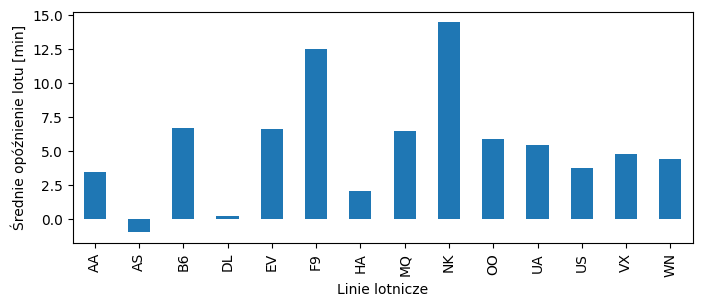

In [ ]:
df_flights.groupby(['AIRLINE'])['ARRIVAL_DELAY'].mean().plot(kind='bar', figsize = (8,3))
plt.ylabel('Średnie opóźnienie lotu [min]')
plt.xlabel('Linie lotnicze')
plt.show()

Maksymalne opóźnienie przylotów w zależności od linii lotniczych

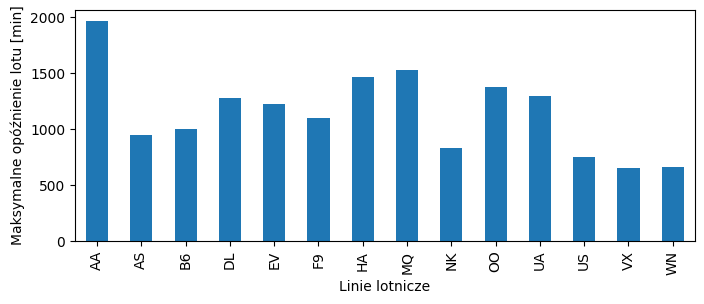

In [ ]:
df_flights.groupby(['AIRLINE'])['ARRIVAL_DELAY'].max().plot(kind='bar', figsize = (8,3))
plt.ylabel('Maksymalne opóźnienie lotu [min]')
plt.xlabel('Linie lotnicze')
plt.show()

Ilość odlotów z poszczególnych lotnisk

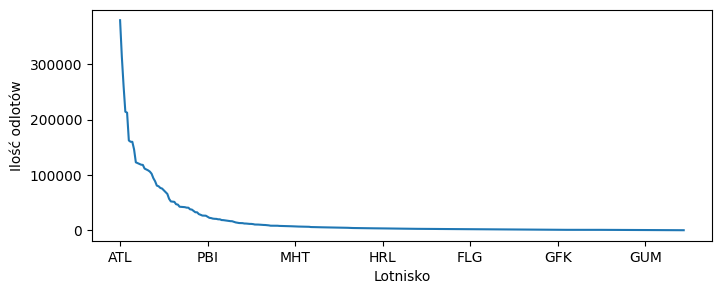

In [ ]:
s = df_flights.groupby(['ORIGIN_AIRPORT'])['DAY'].count()
s.sort_values(ascending=False).plot(figsize = (8,3))
plt.ylabel('Ilość odlotów')
plt.xlabel('Lotnisko')
plt.show()

Rozkład zmiennej target 'ARRIVAL_DELAY'

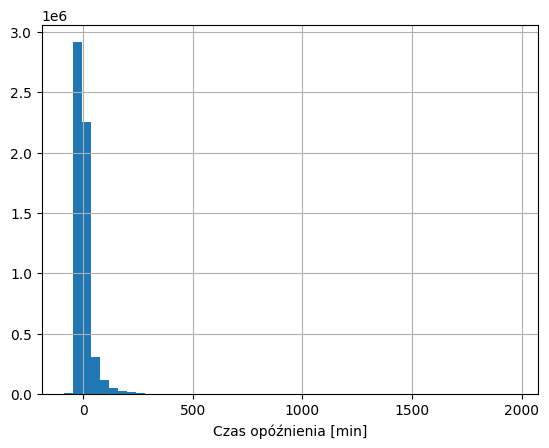

In [ ]:
df_flights['ARRIVAL_DELAY'].hist(bins=50)
plt.xlabel('Czas opóźnienia [min]')
plt.show()

Średnie opóźnienia w poszczególnych miesiącach

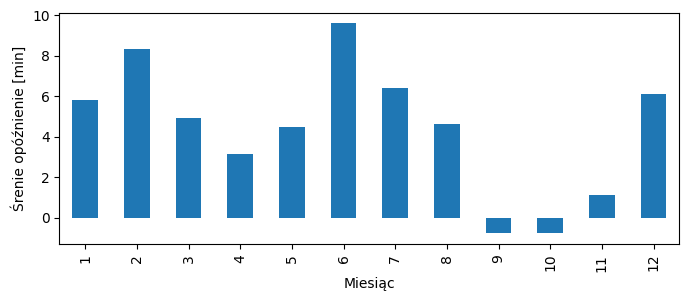

In [ ]:
s = df_flights.groupby(['MONTH'])['ARRIVAL_DELAY'].mean()
s.plot(kind='bar', figsize = (8,3))
plt.ylabel('Śrenie opóźnienie [min]')
plt.xlabel('Miesiąc')
plt.show()

Liczba odlotów w poszczególnych miesiącach - widzimy małą zmienność, we wszytkich miesiącach jest podobna ilość lotów

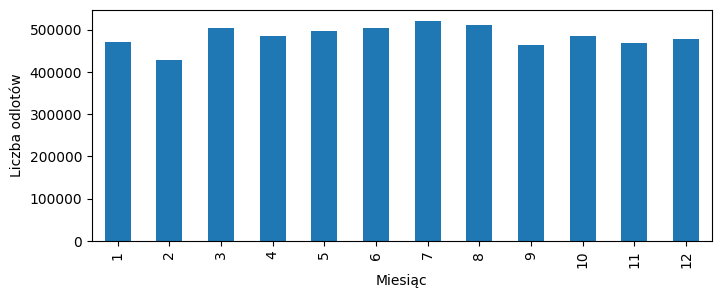

In [ ]:
s = df_flights.groupby(['MONTH'])['MONTH'].count()
s.plot(kind='bar', figsize = (8,3))
plt.ylabel('Liczba odlotów')
plt.xlabel('Miesiąc')
plt.show()

Średnie opóźnienie w poszczególnych dniach tygodnia

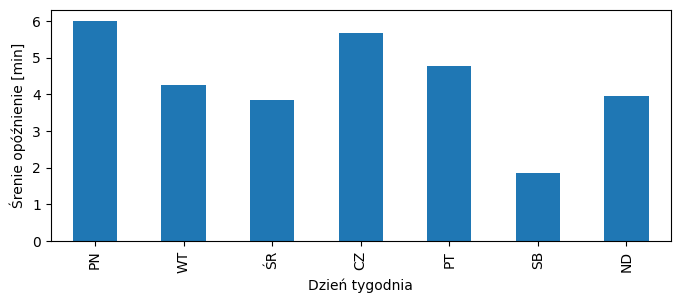

In [ ]:
s = df_flights.groupby(['DAY_OF_WEEK'])['ARRIVAL_DELAY'].mean()
ax = s.plot(kind='bar', figsize = (8,3))
plt.ylabel('Śrenie opóźnienie [min]')
plt.xlabel('Dzień tygodnia')
ax.set_xticklabels(['PN','WT','ŚR','CZ','PT','SB','ND'])
plt.show()

In [6]:
df_flights.describe()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,O_LATITUDE,O_LONGITUDE,D_LATITUDE,D_LONGITUDE
count,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.714008e+06,5.819079e+06,5.819079e+06,5.810050e+06,5.810050e+06,5.810053e+06,5.810053e+06
mean,6.524085e+00,1.570459e+01,3.926941e+00,1.329602e+03,8.223565e+02,4.407057e+00,2.609863e-03,1.544643e-02,3.665407e+01,-9.549028e+01,3.665382e+01,-9.549019e+01
std,3.405137e+00,8.783425e+00,1.988845e+00,4.837518e+02,6.077843e+02,3.927130e+01,5.102012e-02,1.233201e-01,5.988309e+00,1.815323e+01,5.988352e+00,1.815308e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.100000e+01,-8.700000e+01,0.000000e+00,0.000000e+00,1.348345e+01,-1.766460e+02,1.348345e+01,-1.766460e+02
25%,4.000000e+00,8.000000e+00,2.000000e+00,9.170000e+02,3.730000e+02,-1.300000e+01,0.000000e+00,0.000000e+00,3.289595e+01,-1.119778e+02,3.289595e+01,-1.119778e+02
50%,7.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,6.470000e+02,-5.000000e+00,0.000000e+00,0.000000e+00,3.736186e+01,-9.025803e+01,3.736186e+01,-9.025803e+01
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.730000e+03,1.062000e+03,8.000000e+00,0.000000e+00,0.000000e+00,4.078839e+01,-8.168786e+01,4.078839e+01,-8.168786e+01
max,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,4.983000e+03,1.971000e+03,1.000000e+00,1.000000e+00,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01


Sprawdzenie min wartości dla 'DISTANCE' - sprawdzamy odstające wartości.
Po wspólrzędnych widizmy, że obserwacje dotyczą lotów z lotnisk, które są położone w bardzo małej odległości.

In [8]:
df_flights[df_flights['DISTANCE'] < 50].sort_values(by='DISTANCE')

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,O_LATITUDE,O_LONGITUDE,D_LATITUDE,D_LONGITUDE
1714902,4,20,1,AA,EWR,JFK,1040,21,NaN,0,1,40.69250,-74.16866,40.63975,-73.77893
4231,1,1,4,AS,WRG,PSG,1100,31,-14.0,0,0,56.48433,-132.36982,56.80165,-132.94528
3771420,8,22,6,AS,PSG,WRG,1621,31,-4.0,0,0,56.80165,-132.94528,56.48433,-132.36982
3780525,8,23,7,AS,WRG,PSG,1110,31,3.0,0,0,56.48433,-132.36982,56.80165,-132.94528
3785608,8,23,7,AS,PSG,WRG,1623,31,1.0,0,0,56.80165,-132.94528,56.48433,-132.36982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335079,7,27,1,AS,JNU,GST,1625,41,56.0,0,0,58.35496,-134.57628,58.42438,-135.70738
3318926,7,26,7,AS,GST,JNU,1740,41,18.0,0,0,58.42438,-135.70738,58.35496,-134.57628
3317600,7,26,7,AS,JNU,GST,1625,41,9.0,0,0,58.35496,-134.57628,58.42438,-135.70738
3370957,7,29,3,AS,GST,JNU,1740,41,11.0,0,0,58.42438,-135.70738,58.35496,-134.57628


Zależność 'ARRIVAL_DELAY' od 'DISTANCE'

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


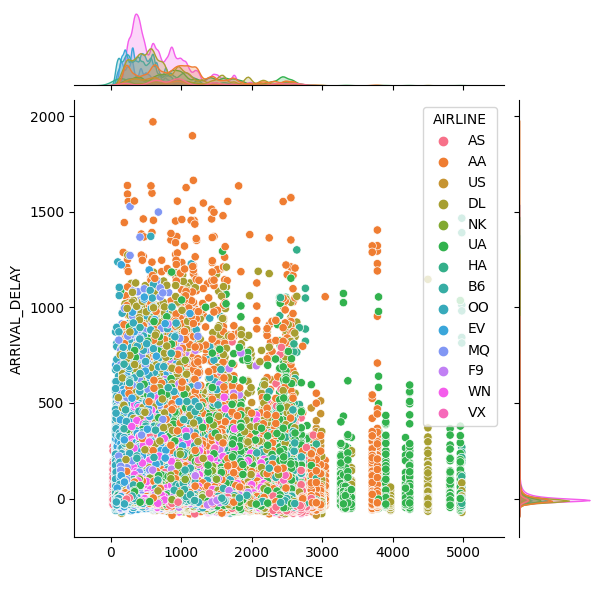

In [ ]:
sns.jointplot(x='DISTANCE', y='ARRIVAL_DELAY', data=df_flights, hue='AIRLINE')

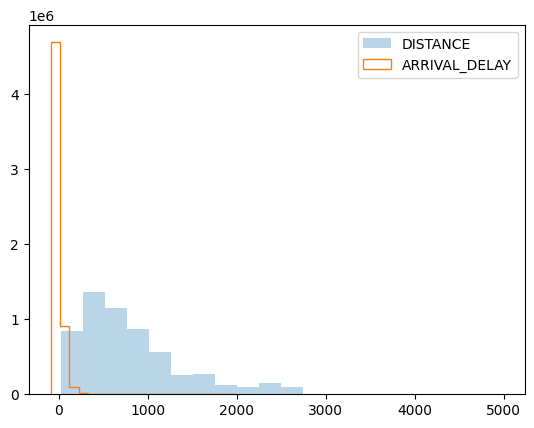

In [ ]:
fig, ax=plt.subplots()
ax.hist(df_flights['DISTANCE'], label='DISTANCE', bins=20, alpha=0.3) # aplha - transparentność koloru
ax.hist(df_flights['ARRIVAL_DELAY'], label='ARRIVAL_DELAY', bins=20, histtype='step')
ax.legend()
plt.show()

# Przygotowanie danych

## Utworzenie kolumny target

Celem jest klasyfikacja do 5 grup:<br>
1. Lot odwołany<br>
2. Lot przekierowany<br>
3. Opóźnienie do 5 minut<br>
4. Opóźnienie w przedziale (5, 60]<br>
5. Opóźnienie powyżej 1 godziny

In [8]:
def classes(data):
  if data['CANCELLED']==1:
    return 0
  elif data['DIVERTED']==1:
    return 1
  elif data['ARRIVAL_DELAY']<=5:
    return 2
  elif data['ARRIVAL_DELAY']<=60:
    return 3
  else:
    return 4


df_flights['labels'] = df_flights.apply(lambda row : classes(row), axis = 1)

Następnie usuwamy kolumny z targetem z danych, które będą wejściowe do modelu.

In [9]:
df_flights.drop(columns=['ARRIVAL_DELAY',	'DIVERTED',	'CANCELLED'], inplace=True)

In [10]:
df_flights.isna().sum()

MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
SCHEDULED_DEPARTURE       0
DISTANCE                  0
O_LATITUDE             9029
O_LONGITUDE            9029
D_LATITUDE             9026
D_LONGITUDE            9026
labels                    0
dtype: int64

## Wypełnienie Nan

In [10]:
for i in ['O_LATITUDE', 'O_LONGITUDE', 'D_LATITUDE', 'D_LONGITUDE']:
  df_flights[i].fillna(value=df_flights[i].mean(), inplace=True)

In [9]:
df_flights.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,O_LATITUDE,O_LONGITUDE,D_LATITUDE,D_LONGITUDE,labels
0,1,1,4,AS,ANC,SEA,5,1448,61.17432,-149.99619,47.44898,-122.30931,2
1,1,1,4,AA,LAX,PBI,10,2330,33.94254,-118.40807,26.68316,-80.09559,2
2,1,1,4,US,SFO,CLT,20,2296,37.61900,-122.37484,35.21401,-80.94313,2
3,1,1,4,AA,LAX,MIA,20,2342,33.94254,-118.40807,25.79325,-80.29056,2
4,1,1,4,AS,SEA,ANC,25,1448,47.44898,-122.30931,61.17432,-149.99619,2


# Nowa kolumna 'WEEK'

Tworzymy nową kolumnę z numerem tygodnia, a dzień i miesiąc usuwamy z danych

In [11]:
days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

def GetWeek(row):
  week = (days_in_month[0:row['MONTH']-1].sum() + row['DAY']) // 7
  return week

df_flights['WEEK'] = df_flights.apply(GetWeek, axis = 1)

del df_flights['MONTH']
del df_flights['DAY']

## Zamiana zmiennych cyklicznych

Konwertowanie danych w celu usunięcia cykliczności zmiennych.<br>
Z danych cyklicznych takich jak dzień, miesiąc, dzień tygodnia i godzina
 tworzymy nowe kolumny poprzez nałożenie na ich wartości funkcji sinus i cosinus.

In [12]:
cols = ['WEEK', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE']
cols_sin = ['WEEK_SIN',	'DAY_OF_WEEK_SIN', 'SCHEDULED_DEPARTURE_SIN']
cols_cos = ['WEEK_COS', 'DAY_OF_WEEK_COS', 'SCHEDULED_DEPARTURE_COS']

In [13]:
df_flights['WEEK'] = df_flights['WEEK'] / 9
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'] / 4

In [14]:
for i in range(len(cols)):
  df_flights[cols_sin[i]] = df_flights[cols[i]].apply(math.sin)
  df_flights[cols_cos[i]] = df_flights[cols[i]].apply(math.cos)

In [15]:
df_flights.drop(columns=['WEEK', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE'], inplace = True)

In [39]:
df_flights.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,O_LATITUDE,O_LONGITUDE,D_LATITUDE,D_LONGITUDE,labels,WEEK_SIN,WEEK_COS,DAY_OF_WEEK_SIN,DAY_OF_WEEK_COS,SCHEDULED_DEPARTURE_SIN,SCHEDULED_DEPARTURE_COS
0,AS,ANC,SEA,1448,61.17432,-149.99619,47.44898,-122.30931,2,0.0,1.0,-0.756802,-0.653644,0.948985,0.315322
1,AA,LAX,PBI,2330,33.94254,-118.40807,26.68316,-80.09559,2,0.0,1.0,-0.756802,-0.653644,0.598472,-0.801144
2,US,SFO,CLT,2296,37.61900,-122.37484,35.21401,-80.94313,2,0.0,1.0,-0.756802,-0.653644,-0.958924,0.283662
3,AA,LAX,MIA,2342,33.94254,-118.40807,25.79325,-80.29056,2,0.0,1.0,-0.756802,-0.653644,-0.958924,0.283662
4,AS,SEA,ANC,1448,47.44898,-122.30931,61.17432,-149.99619,2,0.0,1.0,-0.756802,-0.653644,-0.033179,0.999449


In [16]:
df_flights.drop(columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace = True)

In [15]:
df_flights.head()

,AIRLINE,DISTANCE,O_LATITUDE,O_LONGITUDE,D_LATITUDE,D_LONGITUDE,labels,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,DAY_OF_WEEK_SIN,DAY_OF_WEEK_COS,SCHEDULED_DEPARTURE_SIN,SCHEDULED_DEPARTURE_COS
0,AS,1448,61.17432,-149.99619,47.44898,-122.30931,2,0.479426,0.877583,0.198669,0.980067,-0.756802,-0.653644,0.948985,0.315322
1,AA,2330,33.94254,-118.40807,26.68316,-80.09559,2,0.479426,0.877583,0.198669,0.980067,-0.756802,-0.653644,0.598472,-0.801144
2,US,2296,37.61900,-122.37484,35.21401,-80.94313,2,0.479426,0.877583,0.198669,0.980067,-0.756802,-0.653644,-0.958924,0.283662
3,AA,2342,33.94254,-118.40807,25.79325,-80.29056,2,0.479426,0.877583,0.198669,0.980067,-0.756802,-0.653644,-0.958924,0.283662
4,AS,1448,47.44898,-122.30931,61.17432,-149.99619,2,0.479426,0.877583,0.198669,0.980067,-0.756802,-0.653644,-0.033179,0.999449


## OneHotEncoding

Kolumna 'AIRLINE' jest zmienną kategoryczną, wię potrzebujemy ją zakodować przy pomocy OneHotEncder'a.

In [17]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(df_flights[['AIRLINE']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [18]:
df_flights_ohe = ohe.transform(df_flights[['AIRLINE']])

In [19]:
df_flights_ohe = pd.DataFrame(df_flights_ohe).astype(int)

In [15]:
df_flights_ohe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
list(df_flights_ohe.columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [20]:
df_flights[list(range(14))] = df_flights_ohe

In [21]:
df_flights.drop(columns=['AIRLINE'], inplace=True)

In [22]:
df_flights.columns = df_flights.columns.astype(str)

# Podział na zbiory treningowe i testowe

In [23]:
X = df_flights.loc[:, df_flights.columns!='labels']

In [24]:
y = df_flights['labels']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Dummy

Model Dummy stosujemy dla porównania z pozostałymi modelami

In [50]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02     17877
           1       0.00      0.00      0.00      3151
           2       0.71      0.71      0.71    823650
           3       0.22      0.22      0.22    255109
           4       0.06      0.06      0.06     64029

    accuracy                           0.55   1163816
   macro avg       0.20      0.20      0.20   1163816
weighted avg       0.55      0.55      0.55   1163816



<Axes: >

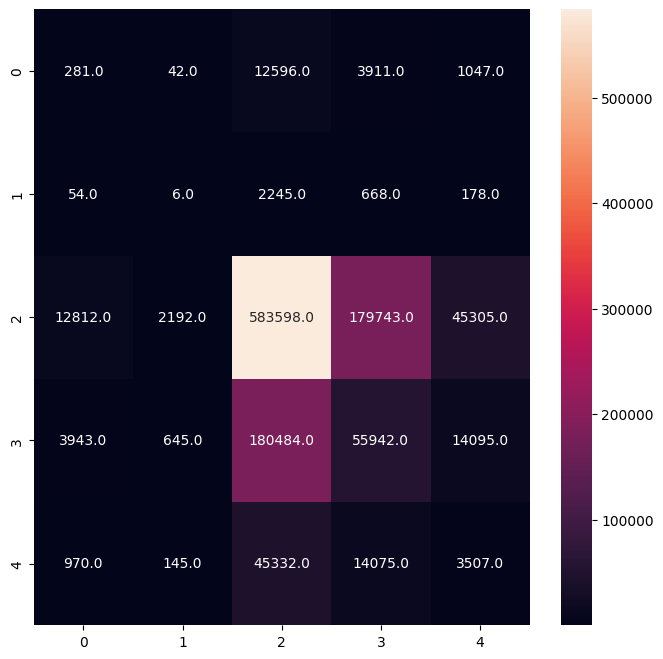

In [26]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='.1f', annot=True)

# RandomForest

In [51]:
X.head()

,DISTANCE,O_LATITUDE,O_LONGITUDE,D_LATITUDE,D_LONGITUDE,WEEK_SIN,WEEK_COS,DAY_OF_WEEK_SIN,DAY_OF_WEEK_COS,SCHEDULED_DEPARTURE_SIN,SCHEDULED_DEPARTURE_COS,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1448,61.17432,-149.99619,47.44898,-122.30931,0.0,1.0,-0.756802,-0.653644,0.948985,0.315322,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2330,33.94254,-118.40807,26.68316,-80.09559,0.0,1.0,-0.756802,-0.653644,0.598472,-0.801144,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2296,37.61900,-122.37484,35.21401,-80.94313,0.0,1.0,-0.756802,-0.653644,-0.958924,0.283662,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2342,33.94254,-118.40807,25.79325,-80.29056,0.0,1.0,-0.756802,-0.653644,-0.958924,0.283662,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1448,47.44898,-122.30931,61.17432,-149.99619,0.0,1.0,-0.756802,-0.653644,-0.033179,0.999449,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Szukamy najlepszych hiperparametrów dla modelu RandomForest

In [25]:
from sklearn.model_selection import GridSearchCV

In [32]:
params = {'criterion':['gini', 'entropy'], 'min_samples_split':[5, 10, 20], 'n_estimators':[5, 10]}
searcher = GridSearchCV(RandomForestClassifier(), params, verbose=2)
searcher.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=gini, min_samples_split=5, n_estimators=5; total time= 1.2min
[CV] END criterion=gini, min_samples_split=5, n_estimators=5; total time= 1.5min
[CV] END criterion=gini, min_samples_split=5, n_estimators=5; total time= 1.1min
[CV] END criterion=gini, min_samples_split=5, n_estimators=5; total time= 1.4min
[CV] END criterion=gini, min_samples_split=5, n_estimators=5; total time= 1.4min
[CV] END criterion=gini, min_samples_split=5, n_estimators=10; total time= 2.6min
[CV] END criterion=gini, min_samples_split=5, n_estimators=10; total time= 2.8min
[CV] END criterion=gini, min_samples_split=5, n_estimators=10; total time= 2.7min
[CV] END criterion=gini, min_samples_split=5, n_estimators=10; total time= 2.7min
[CV] END criterion=gini, min_samples_split=5, n_estimators=10; total time= 2.6min
[CV] END criterion=gini, min_samples_split=10, n_estimators=5; total time= 1.4min
[CV] END criterion=gini, min_samples_split

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [5, 10]},
             verbose=2)

In [33]:
print('Best parameter', searcher.best_params_)

Best parameter {'criterion': 'gini', 'min_samples_split': 20, 'n_estimators': 5}


In [34]:
print('Best score', searcher.best_score_)

Best score 0.25630644236725814


Otrzymane wyniki wrzucamy do modelu.

In [53]:
rf = RandomForestClassifier(n_estimators=5, criterion='gini', min_samples_split=20, class_weight='balanced')

In [54]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.17      0.47      0.25     17877
           1       0.03      0.11      0.05      3151
           2       0.80      0.67      0.73    823650
           3       0.32      0.37      0.35    255109
           4       0.14      0.27      0.19     64029

    accuracy                           0.58   1163816
   macro avg       0.29      0.38      0.31   1163816
weighted avg       0.65      0.58      0.61   1163816



<Axes: >

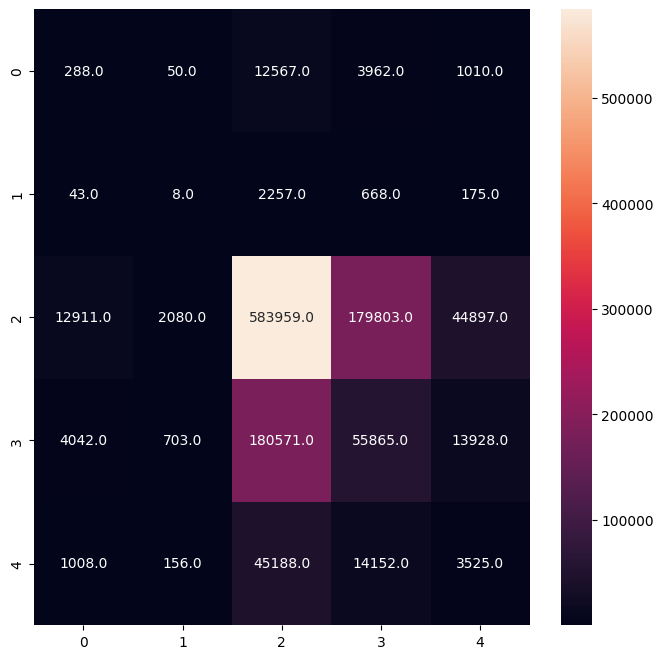

In [55]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='.1f', annot=True)

Większość obserwacji ze zbioru testowego została zaklasyfikowana do klasy 2 - najliczniejszej.<br>
Nieznaczna poprawa w stosunku do wyników z klasyfikatora Dummy.

# Naive Bayes

Kolejny model to naiwny klasyfikator Bayes'a

In [56]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print(classification_report(y_test, y_pred_gnb))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.04      0.39      0.06     17877
           1       0.00      0.00      0.00      3151
           2       0.72      0.75      0.74    823650
           3       0.24      0.02      0.03    255109
           4       0.08      0.12      0.10     64029

    accuracy                           0.55   1163816
   macro avg       0.22      0.26      0.19   1163816
weighted avg       0.57      0.55      0.54   1163816



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

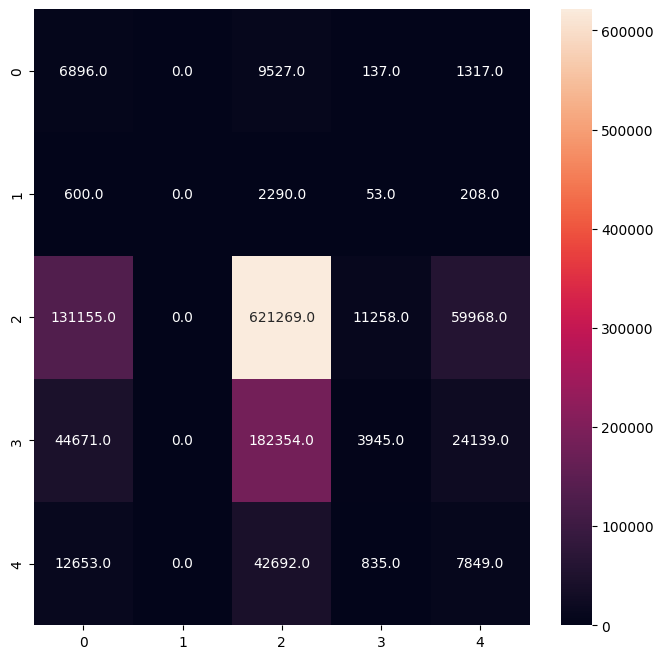

In [58]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred_gnb), fmt='.1f', annot=True)

Wyniki dla klasyfikatora Bayes'a są zblione do RandomForest, więc spróbujemy jeszcze zastosować Bagging

In [28]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.03      0.27      0.06     17877
           1       0.00      0.55      0.01      3151
           2       0.72      0.42      0.53    823650
           3       0.27      0.01      0.01    255109
           4       0.08      0.09      0.09     64029

    accuracy                           0.31   1163816
   macro avg       0.22      0.27      0.14   1163816
weighted avg       0.57      0.31      0.38   1163816



<Axes: >

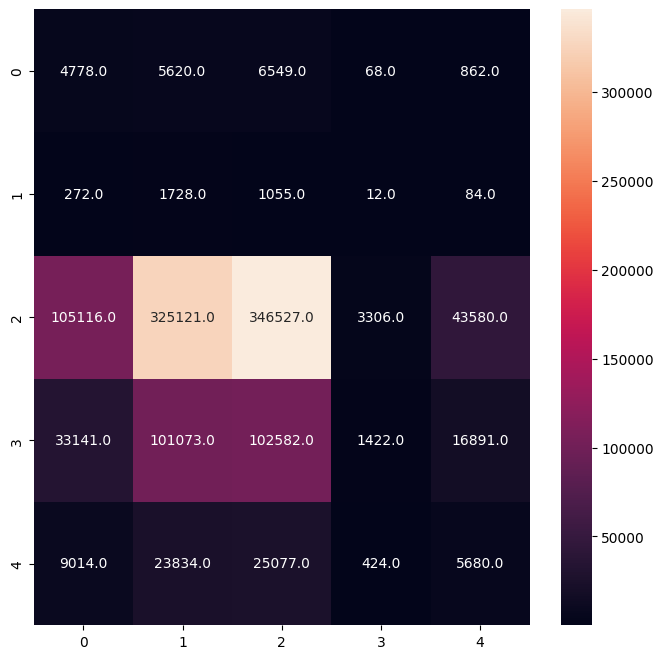

In [30]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred_gnb), fmt='.1f', annot=True)

# BaggingClassifier

In [36]:
from sklearn.ensemble import BaggingClassifier

Sprawdzimy optymalną ilość estymatorów w tym modelu

In [26]:
params = {'n_estimators':[5, 10, 15, 20], 'base_estimator':[GaussianNB()]}
searcher = GridSearchCV(BaggingClassifier(), params, verbose=2)
searcher.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END ........base_estimator=GaussianNB(), n_estimators=5; total time=  37.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END ........base_estimator=GaussianNB(), n_estimators=5; total time=  30.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END ........base_estimator=GaussianNB(), n_estimators=5; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END ........base_estimator=GaussianNB(), n_estimators=5; total time=  34.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END ........base_estimator=GaussianNB(), n_estimators=5; total time=  26.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=10; total time=  52.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=10; total time=  51.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=10; total time=  49.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=10; total time=  48.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=10; total time=  47.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=15; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=15; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=15; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=15; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=15; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=20; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=20; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=20; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=20; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .......base_estimator=GaussianNB(), n_estimators=20; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'base_estimator': [GaussianNB()],
                         'n_estimators': [5, 10, 15, 20]},
             verbose=2)

In [27]:
print('Best parameter', searcher.best_params_)
print('Best score', searcher.best_score_)

Best parameter {'base_estimator': GaussianNB(), 'n_estimators': 10}
Best score 0.5509783227775138


In [37]:
clf = BaggingClassifier(base_estimator=GaussianNB(), n_estimators=10)
clf.fit(X_train, y_train)
y_pred_bag = clf.predict(X_test)
print(classification_report(y_test, y_pred_bag))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.03      0.27      0.06     17877
           1       0.00      0.56      0.01      3151
           2       0.72      0.40      0.52    823650
           3       0.27      0.01      0.01    255109
           4       0.08      0.09      0.09     64029

    accuracy                           0.30   1163816
   macro avg       0.22      0.27      0.14   1163816
weighted avg       0.57      0.30      0.37   1163816



<Axes: >

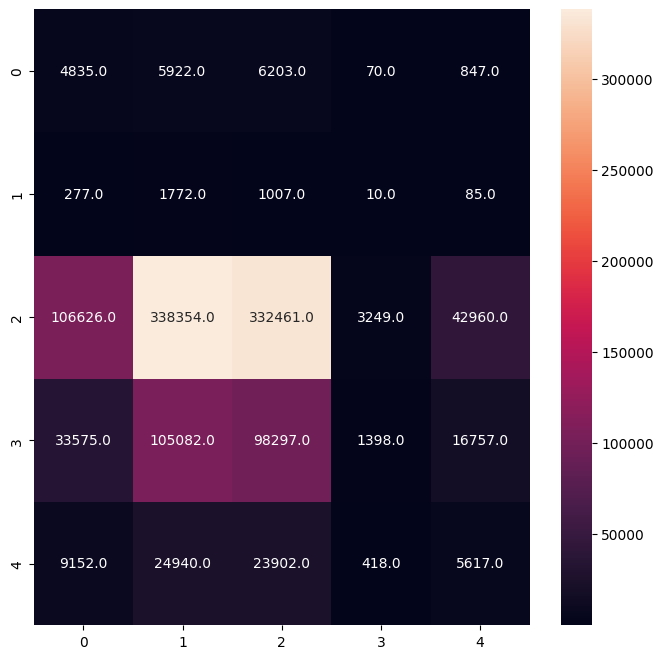

In [38]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred_bag), fmt='.1f', annot=True)

# Podsumowanie i wybór modelu

Wyniki modeli nie są zadowalające. Prawdopodobnie główną przyczyną jest bardzo wysokie niezbalansowanie klas.
W celu symulacji działąnia modelu na produkcji, do predykcji wybrany zostaje Random Forest.
Co prawda model w dużej ilości przypadków klasyfikuje przypadki fałszywie negatywne, czyli w konsekwencji możemy spóźnić się na lot, który będzie o czasie.
Ten przypadek jednak identyfikuje najwięcej danych z róźnych klas.